# Distributed haloes generation
<b>Author</b>: Natalie B. Hogg

## Contents <a name="contents"></a>
1. [Set up](#setup)
2. [Create haloes](#create_haloes)
 1. [Mass](#mass)
 2. [Plectrum region](#plectrum)
 2. [Distances](#distance)
 3. [Remaining parameters](#lenstronomy)
3. [Plot the populated region](#plot)
4. [Compute the shears](#predict_shears)

## Set up <a name="setup"></a>

### Import packages

In [1]:
# computation
import numpy as np
import pandas as pd
import random as r
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault
from mpl_toolkits import mplot3d

# cosmology
from colossus.cosmology import cosmology as colcos
from colossus.lss import mass_function
from colossus.halo import concentration
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import constants as const
from astropy import units as u

# monitoring
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# this is where the figures will be saved
# outpath  = r'/home/natalie/Documents/Projects/los_effects/figures/distributed_haloes/' 
outpath  = '/Users/pierrefleury/Documents/data/haloes/'

job_name = 'test'

### Import `lenstronomy` packages

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

### Useful functions

In [3]:
def show_palette(colour):
    # function for displaying colour palettes
    sns.set_style('whitegrid')
    hex2rgb = []
    for k in colour:
        h = k.lstrip('#')
        hex2rgb.append(tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4)))
    return sns.palplot(hex2rgb)

def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    # phi and q must be passed as lists
    phi = np.array(phi)
    q = np.array(q)
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return list(e1), list(e2)

def distance_conversion(distance, conversion_type):
    # converts a distance *in Mpc* to Gpc, kpc, pc or m
    # careful! it doesn't sanity check your input
    if conversion_type == 'to Gpc':
        new_distance = distance/(10**3)
    elif conversion_type == 'to kpc':
        new_distance = distance*(10**3)
    elif conversion_type == 'to pc':
        new_distance = distance*(10**6)
    elif conversion_type == 'to m':
        new_distance = distance*(3.086*10**22)
    else:
        print('Unknown conversion type')
    return new_distance

def angle_conversion(angle, conversion_type):
    # converts an angle in arcsec to rad or rad to arcsec
    # careful! it doesn't sanity check your input
    conversion_factor = np.pi/(180*3600)
    if conversion_type == 'to arcsecs':
        new_angle = angle/conversion_factor
    elif conversion_type == 'to radians':
        new_angle = angle*conversion_factor
    else:
        print('Unknown conversion type')
    return new_angle

### Global plotting and display settings

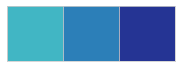

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# have a look at a palette for example
show_palette(cool)

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

### Start the Universe

In [5]:
cosmology = {'id': 'planck18', 'H0': 67.4, 'Om': 0.315}

colcos.setCosmology(cosmology['id'])

cosmo = FlatLambdaCDM(H0 = cosmology['H0'], Om0 = cosmology['Om']) 

G_Newton   = const.G.value # 6.67*10**-11 [m^3 / kg s^2]
clight     = const.c.value # 299792458 [m / s]
clight_kms = clight/1000   # 299792.458 [km / s]
solar_mass = const.M_sun.value # 1.988*10**30 [kg]
parsec     = const.pc.value # 3.08567758*10**16 [m]
Mpc        = 1e6 * parsec

def dC(redshift):
    """
    Returns the comoving distance at a given redshift in Mpc.
    """
    distance = cosmo.comoving_distance(redshift).value
    return distance

def Hubble(redshift):
    """
    Returns H(z) for a given redshift in km/s/Mpc.
    """
    Hofz = cosmo.H(redshift).value
    return Hofz

def dA(z1, z2):
    """
    Returns angular diameter distance between two redshifts in Mpc.
    """
    distance = cosmo.angular_diameter_distance_z1z2(z1, z2).value
    return distance

def redshift_converter(object_distance, units):
    object_redshift = z_at_value(cosmo.comoving_distance, object_distance*units, zmin = -0.0001, zmax=5.)
    return object_redshift

z_observer = 0.0
z_lens     = 0.5
z_source   = 1.5

z_hmf = z_lens

d_observer = 0.0
d_od       = dA(z_observer, z_lens)
d_os       = dA(z_observer, z_source)
d_ds       = dA(z_lens, z_source)

dc_source = dC(z_source)

print('\nThe Hubble parameter being used is {} km/s/Mpc.'.format(cosmo.h*100))
print('The redshifts of the observer, lens and the source are z = {}, z = {:.2} and z = {} respectively.'.format(z_observer, z_lens, z_source))
print('The angular distances between observer and lens, observer and source and lens and source are {:.2f} Mpc, {:.2f} Mpc and {:.2f} Mpc respectively.'.format(d_od, d_os, d_ds))


The Hubble parameter being used is 67.4 km/s/Mpc.
The redshifts of the observer, lens and the source are z = 0.0, z = 0.5 and z = 1.5 respectively.
The angular distances between observer and lens, observer and source and lens and source are 1300.92 Mpc, 1792.84 Mpc and 1012.28 Mpc respectively.


### Create main lens: `EPL` 
At this stage we only need to set an Einstein radius; the rest of the main lens parameters are set in the `distributed_haloes_analysis` notebook.

In [6]:
theta_E = 1 # 1.0 # arcsec

## Create haloes <a name="create_haloes"></a>

[Back to contents](#contents)

### Get the halo mass function using `colossus` <a name="mass"></a>

In [7]:
# mass limits in log space
lower_mass_limit = 8
upper_mass_limit = 15

# define the mass range
mass_range = np.logspace(lower_mass_limit, upper_mass_limit, num=1000) # [MSun/h]

# define the mass, 200 times the critical density of the Universe 
# this choice is consistent with lenstronomy internal definitions -- see lens_cosmo.py)
mdef = '200c' 

hmf_model = 'tinker08' # model for the HMF

# get the HMF
dndlnM = mass_function.massFunction(mass_range, z_hmf, q_in='M', q_out='dndlnM', mdef=mdef, model=hmf_model)

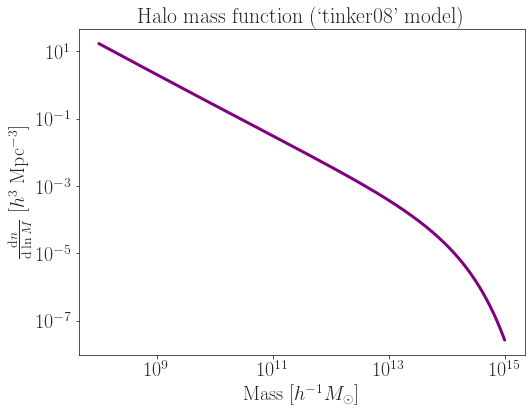

In [8]:
# plot the HMF
plt.figure(figsize = (8,6))
plt.title(r"Halo mass function (`{}' model)".format(hmf_model))
plt.plot(mass_range, dndlnM, lw = 3, color = 'purple')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Mass [$h^{-1} M_{\odot}$]', fontsize = 20)
plt.ylabel(r'$\frac{\mathrm{d}n}{\mathrm{d}\ln M}$ [$h^3$ Mpc$^{-3}$]', fontsize = 20)
plt.show()

In [9]:
# check: does the mass function match the cosmic mean density?
rho_hmf = trapezoid(dndlnM*cosmo.h**3, mass_range/cosmo.h) # [M_sun/Mpc^3]
rho_hmf *= (solar_mass * 1e3) / (1e2 * Mpc)**3 # [g/cm3]
rho_m = cosmo.Om0 * cosmo.critical_density(0) # [g/cm3]
print("The comoving density predicted from the HMF is {:e} g/cm3".format(rho_hmf))
print("The cosmic comoving density is {:e}".format(rho_m))

The comoving density predicted from the HMF is 1.255416e-30 g/cm3
The cosmic comoving density is 2.687849e-30 g / cm3


### Relevant region of space to be considered

We start with a region of space that is a comoving cylinder with length $\chi_{\rm s}$ (comoving distance between the observer and the source) and radius $R_0$, which we fix in such a way that a point lens with mass $M$ at a comoving distance $R_0$ from the optical axis would produce a shear of magnitude $\varepsilon$ if it lay half-way ($\chi_{1/2}=\chi_{\rm s}/2$) between the observer and the source. This implies
$$
R_0
= \frac{r_{\rm E}}{\sqrt{\varepsilon}}
= \sqrt{\frac{GM\chi_{\rm s}}{c^2(1+z_{1/2})\varepsilon}}
$$

In [10]:
# compute R_0
M = 1e12 * solar_mass # [kg] 
eps = 1e-6
chis = dC(z_source) * 1e6 * parsec # [m]
z12 = z_at_value(cosmo.comoving_distance, cosmo.comoving_distance(z_source)/2)
R_0_m = np.sqrt(G_Newton * M * chis / clight**2 / (1 + z12) / eps) # [m]
R_0 = R_0_m / (1e6 * parsec) # [Mpc]

print('The comoving radius R0 of the region is {:.3f} Mpc'.format(R_0))

The comoving radius R0 of the region is 3.675 Mpc


In [11]:
n_c = trapezoid(dndlnM/mass_range, x=mass_range) # [h^3/Mpc^3]
n_c *= (cosmo.h)**3 # [Mpc^-3]
V = np.pi * (R_0**2.) * dc_source
cylinder_halo_number = int(n_c * V)

print('Number density of haloes: {:.2f} Mpc^-3'.format(n_c))
print('Comoving volume of the cylinder: {:.2e} Mpc^3'.format(V))
print('Number of haloes in cylinder: {:.2e}.'.format(cylinder_halo_number))

Number density of haloes: 5.60 Mpc^-3
Comoving volume of the cylinder: 1.90e+05 Mpc^3
Number of haloes in cylinder: 1.06e+06.


### Create halo dataframe <a name="distance"></a>

In [12]:
# create dataframe for halo parameters
# d is the comoving distance along the LOS to the halo [Mpc]
# z is the redshift to that distance
# r is the physical distance from the LOS [Mpc]
# x_phys and y_phys are the physical coordinates of the halo on the plane orthogonal to the LOS [Mpc]
# center_x and center_y are the coordinates of the halo in arcsec, passed to lenstronomy in kwargs_nfw [arcsec]
# mass is the mass of the halo [MSun]

haloes_dataframe = pd.DataFrame(columns = ['d', 'z', 'r', 'x_com', 'y_com','center_x', 'center_y', 'mass'])

### Create distances

In [13]:
halo_distance_list = np.random.uniform(d_observer, dc_source, cylinder_halo_number)
haloes_dataframe['d'] = halo_distance_list

### Convert to redshifts

In [14]:
z_grid   = np.linspace(z_observer, z_source, 101)
chi_grid = dC(z_grid)
z_of_chi   = interp1d(chi_grid, z_grid)

halo_redshift_list = z_of_chi(halo_distance_list)
haloes_dataframe['z'] = halo_redshift_list

### Halo transverse distances
Draw physical distance of each halo from LOS randomly on a disk.

In [15]:
r_sq = np.random.uniform(0.0, R_0**2., cylinder_halo_number)
r_com = np.sqrt(r_sq)

theta = np.random.uniform(0.0, 2.0*np.pi, cylinder_halo_number)

x_com = r_com*np.cos(theta)
y_com = r_com*np.sin(theta)

haloes_dataframe['r'] = r_com

haloes_dataframe['x_com'] = x_com
haloes_dataframe['y_com'] = y_com

haloes_dataframe['center_x'] = tqdm(angle_conversion(haloes_dataframe['x_com']/haloes_dataframe['d'], 'to arcsecs'))
haloes_dataframe['center_y'] = tqdm(angle_conversion(haloes_dataframe['y_com']/haloes_dataframe['d'], 'to arcsecs'))

  0%|          | 0/1064305 [00:00<?, ?it/s]

  0%|          | 0/1064305 [00:00<?, ?it/s]

### Get the lenstronomy `NFW` parameters <a name="lenstronomy"></a>

#### Mass

In [16]:
# draw halo masses from the original mass range, weighted by the HMF
halo_mass_inverse_h = r.choices(mass_range, dndlnM, k=cylinder_halo_number) # [MSun/h]
halo_mass = np.array(halo_mass_inverse_h)

# convert to units of MSun
halo_mass /= cosmo.h # [MSun]

# save to dataframe
haloes_dataframe['mass'] = halo_mass # [MSun]

In [17]:
# check that the comoving density matches the cosmic comoving density
M_tot = halo_mass.sum()
rho_sample = M_tot / V # [solar masses per Mpc^3]
rho_sample *= (solar_mass * 1e3) / (1e2 * Mpc)**3 # [g/cm3]
rho_m = cosmo.Om0 * cosmo.critical_density(0) # [g/cm3]
print("The mean comoving density in the cylinder is {:e} g/cm3".format(rho_sample))
print("The comoving density predicted from the HMF is {:e} g/cm3".format(rho_hmf))
print("The cosmic comoving density is {:e}".format(rho_m))

The mean comoving density in the cylinder is 1.232911e-30 g/cm3
The comoving density predicted from the HMF is 1.255416e-30 g/cm3
The cosmic comoving density is 2.687849e-30 g / cm3


#### Concentration

In [18]:
# use colossus to get the halo concentration
# concentration parameter is the ratio of the virial radius to the scale radius
# we use the same redshift as for the HMF so that the masses and concentrations are consistent

concentration_model = 'diemer15'

halo_concentration_inverse_h = concentration.concentration(M = np.array(halo_mass_inverse_h), 
                                                            mdef = mdef, 
                                                            z = z_hmf,  
                                                            model = concentration_model)

# convert to units of MSun
halo_concentration = list(np.array(halo_concentration_inverse_h) * cosmo.h) # [MSun]

# add to dataframe
haloes_dataframe['concentration'] = halo_concentration # [MSun]

#### Remove all haloes whose shear is below a certain threshold
For the sake of speed, we use the point lens approximation to compute the shear for this step, as it is faster than calling the `lenstronomy` function on each individual halo in a population this size.

In [19]:
def comoving_rE2(M, z, chi, chi_s):
    """
    Computes the comoving squared Einstein radius of a point lens in Mpc^2,
    M: mass of the lens in solar masses
    z: redshift of the lens
    chi: comoving distance to the observer in Mpc
    chis: comoving distance to the source in Mpc
    """
    
    mass_array = np.array(M)
    chi_array = np.array(chi)
    
    # convert in SI
    mass_array *= solar_mass # [kg]
    chi_array *= 1e6 * parsec
    chi_s *= 1e6 * parsec
    
    # compute the squared Einstein radius
    rE2 = 4*G_Newton*mass_array/clight**2.*(1 + np.array(z))*chi_array*(chi_s - chi_array)/chi_s # [m^2]
    rE2 /= (1e6 * parsec)**2 # [Mpc^2]
    
    return rE2

rE2 = comoving_rE2(halo_mass, halo_redshift_list, halo_distance_list, dc_source) #[Mpc^2]

point_lens_gamma_list = rE2/r_sq

haloes_dataframe['plg'] = point_lens_gamma_list

In [20]:
minimum_shear = eps

small_gammas = [i for i in point_lens_gamma_list if i < minimum_shear]

gamma_percent = (len(small_gammas)/cylinder_halo_number)*100

print('There are {} haloes out of {} with a shear less than {} ({:.3f}%).'.format(len(small_gammas), cylinder_halo_number, minimum_shear, gamma_percent))
print('You\'re left with {} haloes!'.format(cylinder_halo_number-len(small_gammas)))

There are 1060855 haloes out of 1064305 with a shear less than 1e-05 (99.676%).
You're left with 3450 haloes!


In [21]:
shaped_haloes_dataframe = haloes_dataframe.loc[(haloes_dataframe['plg'] > minimum_shear)]
shaped_halo_number = len(shaped_haloes_dataframe)

In [22]:
# new quantities for iterating over
shaped_halo_redshift_list = shaped_haloes_dataframe['z'].to_list()
shaped_halo_mass          = shaped_haloes_dataframe['mass'].to_list()
shaped_halo_concentration = shaped_haloes_dataframe['concentration'].to_list()

# OS

### Scale radius and deflection angle at scale radius
These should be in units without little h.

In [23]:
Rs_angle = []
alpha_Rs_os = []

for i in tqdm(range(shaped_halo_number)):
    # get the quantities for each halo's redshift
    lens_cosmo = LensCosmo(z_lens=shaped_halo_redshift_list[i],
                           z_source=z_source,
                           cosmo=cosmo)
    
    angles = lens_cosmo.nfw_physical2angle(M=shaped_halo_mass[i],
                                           c=shaped_halo_concentration[i])
    Rs_angle.append(float(angles[0]))
    alpha_Rs_os.append(float(angles[1]))

# add to the dataframe
shaped_haloes_dataframe['Rs'] = Rs_angle # [arcsec]
shaped_haloes_dataframe['alpha_Rs'] = alpha_Rs_os # [arcsec]

  0%|          | 0/3450 [00:00<?, ?it/s]

### Compute the convergence and shear of individual haloes at $x = y = 0$

In [24]:
# get the parameters needed for the lenstronomy kwargs and convert to a list of dictionaries
kwargs_nfw = shaped_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')

single_halo_lens_model = LensModel(lens_model_list=['NFW'], z_source=z_source)

gamma1_ohs = []
gamma2_ohs = []
kappa_ohs  = []

for i in tqdm(range(shaped_halo_number)):
    single_gamma = single_halo_lens_model.gamma(x=0.0, y=0.0, kwargs=[kwargs_nfw[i]])
    gamma1_ohs.append(float(single_gamma[0]))
    gamma2_ohs.append(float(single_gamma[1]))
    
    single_kappa = single_halo_lens_model.kappa(x=0.0, y=0.0, kwargs=[kwargs_nfw[i]])
    kappa_ohs.append(float(single_kappa))
    
shaped_haloes_dataframe['gamma1_ohs'] = gamma1_ohs
shaped_haloes_dataframe['gamma2_ohs'] = gamma2_ohs 
shaped_haloes_dataframe['kappa_ohs']  = kappa_ohs

  0%|          | 0/3450 [00:00<?, ?it/s]

### Compute the convergence and shear of individual haloes at $x=\theta_{\rm E}$ or $y=\theta_{\rm E}$

In [25]:
gamma1_thetaE_x = []
gamma2_thetaE_x = []

gamma1_thetaE_y = []
gamma2_thetaE_y = []

for i in tqdm(range(shaped_halo_number)):
    gamma_thetaE_x = single_halo_lens_model.gamma(x = theta_E, y = 0.0, kwargs = [kwargs_nfw[i]])
    gamma1_thetaE_x.append(float(gamma_thetaE_x[0]))
    gamma2_thetaE_x.append(float(gamma_thetaE_x[1]))
    gamma_thetaE_y = single_halo_lens_model.gamma(x = 0.0, y = theta_E, kwargs = [kwargs_nfw[i]])
    gamma1_thetaE_y.append(float(gamma_thetaE_y[0]))
    gamma2_thetaE_y.append(float(gamma_thetaE_y[1]))

  0%|          | 0/3450 [00:00<?, ?it/s]

### Negative convergence for compensation
Since we are adding mass to the Universe by adding haloes, we must compensate it by adding negative mass in order to compensate. In principle we should respect the mean density of the Universe, but here since the haloes are not uniformly distributed due to the shear cut, we decide instead to add a mass sheet with convergence corresponding to the convergence of each halo on the LOS. This is not physically very consistent, but it should work.

In [26]:
kappa_neg = [-k for k in kappa_ohs]
shaped_haloes_dataframe['kappa_neg'] = kappa_neg

### Compute the total (os) displacement, convergence and shear

In [27]:
# Define the (os) setup without the main lens

lens_model_list = ['NFW'] * shaped_halo_number + ['CONVERGENCE'] * shaped_halo_number
lens_redshift_list = 2 * shaped_haloes_dataframe['z'].to_list()
kwargs_neg = [{'kappa': k} for k in shaped_haloes_dataframe['kappa_neg']]
kwargs_lens = kwargs_nfw + kwargs_neg

mp_os_lens_model = LensModel(lens_model_list = lens_model_list, 
                             z_source=z_source,
                             lens_redshift_list=lens_redshift_list,
                             multi_plane=True)

In [28]:
# Compute the (os) displacement
alpha1_os, alpha2_os = mp_os_lens_model.alpha(x=0.0, y=0.0, kwargs=kwargs_lens)
print(
"The total expected (os) displacement is\n\
alpha1_os = {:.2f} arcsec\n\
alpha2_os = {:.2f} arcsec\n".format(alpha1_os, alpha2_os))

# Compute the total (os) convergence and shear
kappa_os = mp_os_lens_model.kappa(x=0.0, y=0.0, kwargs=kwargs_lens)
gamma1_os, gamma2_os = mp_os_lens_model.gamma(x=0.0, y=0.0, kwargs=kwargs_lens)
print(
"The total expected (os) convergence and shear are\n\
kappa_os = {:.3f}\n\
gamma1_os = {:.3f}\n\
gamma2_os = {:.3f}".format(kappa_os, gamma1_os, gamma2_os))

The total expected (os) displacement is
alpha1_os = 7.65 arcsec
alpha2_os = -4.46 arcsec

The total expected (os) convergence and shear are
kappa_os = 0.019
gamma1_os = -0.003
gamma2_os = 0.068


In [29]:
# Compare with the shear obtained from the sum of individual shears

gamma1_os_sum = sum(gamma1_ohs)
gamma2_os_sum = sum(gamma2_ohs)
print("The (os) shear obtained by summing the individual halo (os) shears is:\n\
gamma1_os_sum = {:.3f}\n\
gamma2_os_sum = {:.3f}".format(gamma1_os_sum, gamma2_os_sum))

The (os) shear obtained by summing the individual halo (os) shears is:
gamma1_os_sum = -0.021
gamma2_os_sum = 0.042


### Histogram of the shear components

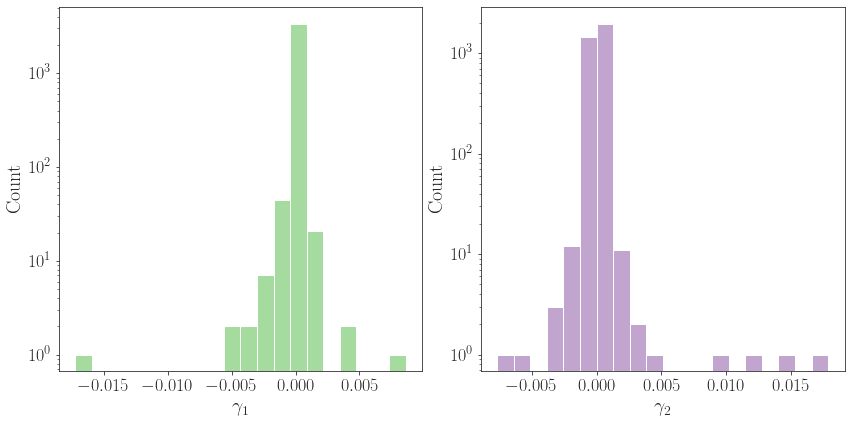

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)
fig.tight_layout()

for a, g, c in zip(ax, [gamma1_ohs, gamma2_ohs], [green[0], purple[0]]):
    a.hist(g, bins = 20, color = c)
    a.set_yscale('log')
    a.set_xlabel('$\gamma_{}$'.format([gamma1_ohs, gamma2_ohs].index(g)+1), fontsize=20)
    a.set_ylabel('Count', fontsize=20)
plt.savefig(outpath + job_name + '_gamma_os_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Histogram of the convergence

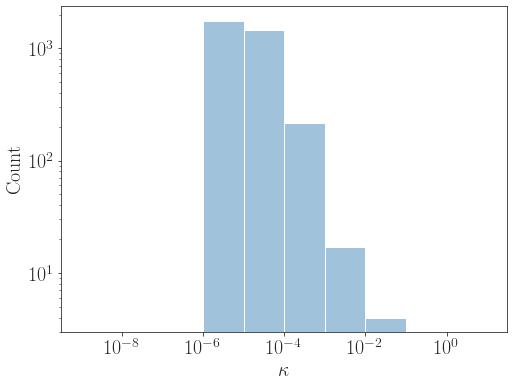

In [31]:
bins = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(kappa_ohs, bins = bins, color = analogous[0])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\kappa$', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.savefig(outpath + job_name + '_kappa_os_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Safety net: remove haloes based on convergence
We check the convergence of each halo; if $\kappa > 1$, the halo is acting as a strong lens rather than a perturber and should be removed from the population. To be doubly sure we are getting rid of all the problematic haloes, we remove all with $\kappa > 0.5$.

In [32]:
maximum_convergence = 0.5

bad_kappas = [i for i in kappa_ohs if i > maximum_convergence]

kappa_percent = (len(bad_kappas)/shaped_halo_number)*100

print('There are {} haloes out of {} with a convergence greater than {} ({:.1f}%).'.format(len(bad_kappas), shaped_halo_number, maximum_convergence, kappa_percent))

There are 0 haloes out of 3450 with a convergence greater than 0.5 (0.0%).


### Safety net II: remove haloes based on shear gradient

In [33]:
def shear_gradient(g1_Ex, g2_Ex, g1_Ey, g2_Ey, g1, g2):
    Del_x_1  = g1_Ex - g1
    Del_x_2  = g2_Ex - g2
    Del_x_sq = (Del_x_1)**2. + (Del_x_2)**2.
    Del_y_1  = g1_Ey - g1
    Del_y_2  = g2_Ey - g2
    Del_y_sq = (Del_y_1)**2. + (Del_y_2)**2.
    Del      = np.sqrt((Del_x_sq + Del_y_sq)/(g1**2. + g2**2.))
    return Del

In [34]:
Del = []

for i in tqdm(range(shaped_halo_number)):
    Del.append(shear_gradient(gamma1_thetaE_x[i],
                              gamma2_thetaE_x[i],
                              gamma1_thetaE_y[i],
                              gamma2_thetaE_y[i],
                              gamma1_ohs[i],
                              gamma2_ohs[i]))
    
shaped_haloes_dataframe['Del'] = Del

  0%|          | 0/3450 [00:00<?, ?it/s]

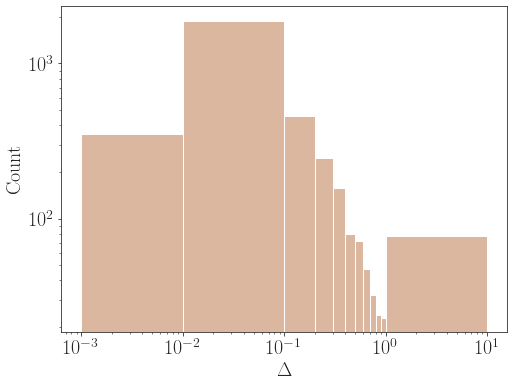

In [35]:
%matplotlib inline
bins = [1e-3, 1e-2, 1e-1, 0.1e0, 0.2e0, 0.3e0, 0.4e0, 0.5e0, 0.6e0, 0.7e0, 0.8e0, 0.9e0, 1e0, 1e1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(Del, bins = bins, color = analogous[1])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\Delta$', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.savefig(outpath + job_name + '_Del_histogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
maximum_Del = 0.1

bad_Dels = [i for i in Del if i > maximum_Del]

Del_percent = (len(bad_Dels)/shaped_halo_number)*100

print('There are {} haloes out of {} with a Del greater than {} ({:.2f}%).'.format(len(bad_Dels), shaped_halo_number, maximum_Del, Del_percent))

There are 1219 haloes out of 3450 with a Del greater than 0.1 (35.33%).


### Update the halo population

In [37]:
# split the halo dataframe into good and bad
discarded_haloes_dataframe = shaped_haloes_dataframe.loc[(shaped_haloes_dataframe['kappa_ohs'] > maximum_convergence) | (shaped_haloes_dataframe['Del'] > maximum_Del)]
surviving_haloes_dataframe = shaped_haloes_dataframe.loc[(shaped_haloes_dataframe['kappa_ohs'] <= maximum_convergence) & (shaped_haloes_dataframe['Del'] <= maximum_Del)]

discarded_halo_number = len(discarded_haloes_dataframe)
surviving_halo_number = len(surviving_haloes_dataframe)

# check the split is correct
assert discarded_halo_number + surviving_halo_number == shaped_halo_number

## Plot the populated region<a name="plot"></a>
We can plot it in projection or in 3D.

[Back to contents](#contents)

In [38]:
# for large numbers of haloes the plot below fills up
# so we can choose a percentage of the haloes to plot as an example
# and change the marker style depending on the number of points that will be plotted

plot_percent = 10
cut_percent = 10
    
cut = int((surviving_halo_number/100)*plot_percent)
cut_discarded = int((discarded_halo_number/100)*cut_percent)

if cut > 2000:
    marker = '.'
    alpha = 0.2
    size = (5,5)
else:
    marker = 'o'
    alpha = 1.0
    size=(10,10)

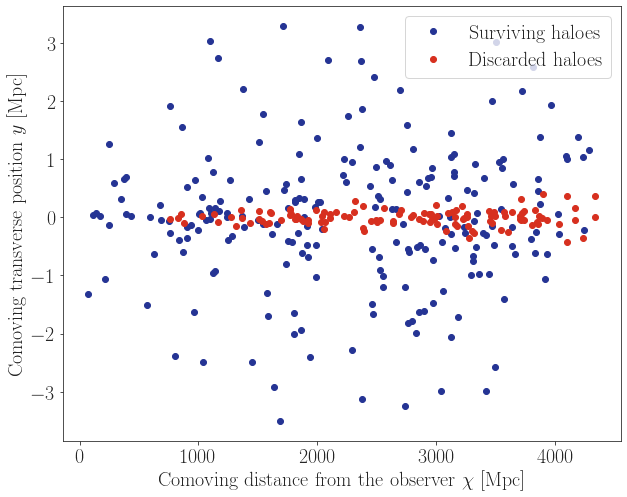

In [39]:
%matplotlib inline

plt.figure(figsize = (10, 8))

plt.plot(surviving_haloes_dataframe['d'][:cut], surviving_haloes_dataframe['y_com'][:cut], 
         color = cool[2], ls = ' ', marker = marker, alpha = alpha,
         label = 'Surviving haloes', rasterized=True)

plt.plot(discarded_haloes_dataframe['d'][:cut_discarded], discarded_haloes_dataframe['y_com'][:cut_discarded], 
         color = warm[2], ls = ' ', marker = marker, alpha = alpha, 
         label = 'Discarded haloes', rasterized=True)

# plt.xlim(z_observer, z_source)
# plt.ylim(-0.5, 0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Comoving distance from the observer $\chi$ [Mpc]', fontsize=20)
plt.ylabel('Comoving transverse position $y$ [Mpc]', fontsize=20)
plt.legend(loc = 'upper right', fontsize=20)

plt.savefig(outpath + job_name + '_region_rasterised_comoving.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [40]:
# %matplotlib notebook
# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# # plt.title('Plot shows {}\% of each population'.format(plot_percent))
# # ax.plot3D(d, np.zeros(len(d)), np.zeros(len(d)), ls = '--', color = 'k', alpha = 0.3)
# ax.scatter3D(surviving_haloes_dataframe['d'][:cut], 
#              surviving_haloes_dataframe['x_com'][:cut], 
#              surviving_haloes_dataframe['y_com'][:cut], color = cool[2],  marker = marker, alpha = 0.2);
# ax.scatter3D(discarded_haloes_dataframe['d'][:cut_discarded], 
#              discarded_haloes_dataframe['x_com'][:cut_discarded], 
#              discarded_haloes_dataframe['y_com'][:cut_discarded], color = warm[2],  marker = marker, alpha = 0.2);
# ax.set_xlabel('Comoving distance from the observer $\chi$ [Mpc]')
# ax.set_ylabel('Physical $x$ [Mpc]')
# ax.set_zlabel('Physical $y$ [Mpc]')

# plt.savefig(outpath + job_name + '_volume.pdf', dpi=300, bbox_inches='tight', transparent=True)

# plt.show()

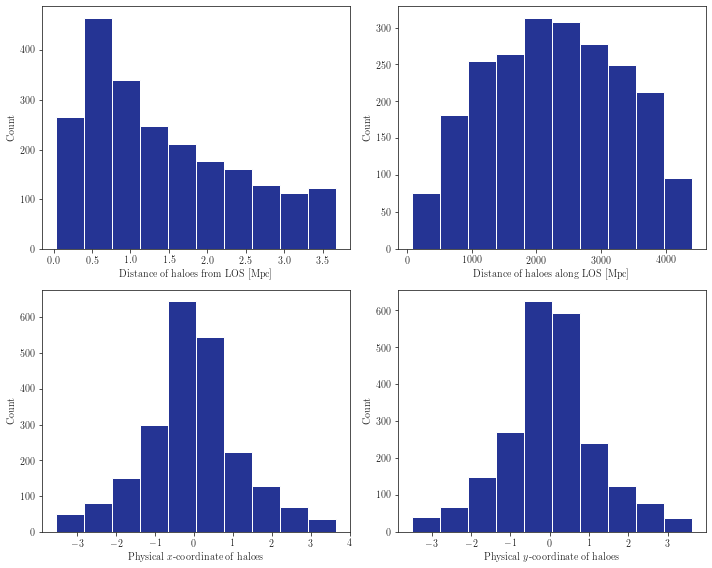

In [41]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(10,8), sharey=False)

ax[0,0].hist(surviving_haloes_dataframe['r'], color = cool[2])
ax[0,0].set_xlabel('Distance of haloes from LOS [Mpc]')

ax[0,1].hist(surviving_haloes_dataframe['d'], color = cool[2])
ax[0,1].set_xlabel('Distance of haloes along LOS [Mpc]')

ax[1,0].hist(surviving_haloes_dataframe['x_com'], color = cool[2])
ax[1,0].set_xlabel('Physical $x$-coordinate of haloes')

ax[1,1].hist(surviving_haloes_dataframe['y_com'], color = cool[2])
ax[1,1].set_xlabel('Physical $y$-coordinate of haloes')

for a in ax.flat:
    a.set_ylabel('Count')
    
fig.tight_layout()

plt.show()

In [42]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plt.hist(discarded_haloes_dataframe['d'], color = warm[2])
# plt.axvline(dC(z_lens), color = 'k', ls = '--', alpha = 0.3, label = 'Position of main lens')
# plt.xlim(0, dC(z_source))
# plt.xlabel('$\chi$ [Mpc]')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

In [43]:
# print('The masses and concentrations of the problematic haloes are, in descending mass order:\n')
# print(discarded_haloes_dataframe.sort_values('mass', ascending = False)[['mass', 'concentration']])
# print('\nThe shear parameters of the problematic haloes are:\n'.format(len(discarded_haloes_dataframe)))
# print(discarded_haloes_dataframe.sort_values('Del', ascending = False)[['gamma1', 'gamma2', 'Del']])
# print('\nThe shear parameters of the first {} surviving haloes are:\n'.format(len(discarded_haloes_dataframe)))
# print(surviving_haloes_dataframe.sort_values('Del', ascending = False)[['gamma1', 'gamma2', 'Del']][:len(discarded_haloes_dataframe)])

### Sanity check I: compare the Einstein radius of the halo with largest shear with its distance from the LOS 

In [44]:
# get the index of the halo with largest gamma1
shear_magnitude = np.sqrt(shaped_haloes_dataframe['gamma1_ohs']**2
                        + shaped_haloes_dataframe['gamma2_ohs']**2)
max_shear = shear_magnitude.max()
max_shear_halo_index = shear_magnitude.idxmax()
max_shear_halo = shaped_haloes_dataframe.loc[[max_shear_halo_index]]

# compute the Einstein radius for this halo assuming it's a point mass
max_shear_halo_redshift = float(max_shear_halo['z'])
max_shear_halo_mass = float(max_shear_halo['mass'])
max_shear_halo_mass_kg = max_shear_halo_mass*solar_mass

prefactor = (4*G_Newton*max_shear_halo_mass_kg)/(clight**2.)

d_ds_m = distance_conversion(dA(max_shear_halo_redshift, z_source), 'to m')
d_os_m = distance_conversion(dA(z_observer, z_source), 'to m')
d_od_m = distance_conversion(dA(z_observer, max_shear_halo_redshift), 'to m')

distance_combination = d_ds_m/(d_os_m*d_od_m)

einstein_radius = np.sqrt(prefactor*distance_combination)

print('The Einstein radius of the halo with the largest gamma={:.3f} is {:.2f} arcsec.'.format(max_shear, angle_conversion(einstein_radius, 'to arcsecs')))

max_shear_halo_x = float(max_shear_halo['center_x'])
max_shear_halo_y = float(max_shear_halo['center_y'])

euclid = np.sqrt(max_shear_halo_x**2. + max_shear_halo_y**2.)

print('The distance between the LOS and this halo is {:.2f} arcsec.'.format(euclid))

print('If these two numbers are roughly the same order of magnitude we are good to go.')

The Einstein radius of the halo with the largest gamma=0.025 is 18.34 arcsec.
The distance between the LOS and this halo is 83.71 arcsec.
If these two numbers are roughly the same order of magnitude we are good to go.


### Sanity check II: matter density from the remaining haloes

In [45]:
total_mass = shaped_haloes_dataframe['mass'].sum()

volume = np.pi * R_0**2 * dC(z_source)
density = total_mass/volume
cgs_conversion = (1000*solar_mass)/(100*Mpc)**3
density_cgs = density * cgs_conversion

rho_m = cosmo.Om0 * cosmo.critical_density(z_observer).value

print('The matter density in the comoving cylinder volume is {:.3e} g/cm^3.'.format(density_cgs))
print('The matter density of the Universe at z = {:.2} is {:.3e} g/cm^3.'.format(z_observer, rho_m))
print('If the former is quite smaller than the latter then we are good to go.')

The matter density in the comoving cylinder volume is 6.491e-31 g/cm^3.
The matter density of the Universe at z = 0.0 is 2.688e-30 g/cm^3.
If the former is quite smaller than the latter then we are good to go.


## Predict the LOS terms: all the haloes <a name="predict_shears"></a>

This is done for the complete haloes dataframe, problematic haloes included. The problematic haloes are removed and the shear terms recomputed in the `distributed_haloes_cutter` notebook.

[Back to contents](#contents)

In [46]:
# make a dataframe to save them
shears_dataframe = pd.DataFrame(columns = ['gamma1_os', 'gamma2_os', 'kappa_os', 'alpha1_os', 'alpha2_os',
                                           'gamma1_od', 'gamma2_od', 'kappa_od', 'alpha1_od', 'alpha2_od',
                                           'gamma1_ds', 'gamma2_ds', 'kappa_ds',
                                           'gamma1_los', 'gamma2_los', 'kappa_los'])

# dummy row so we can write scalars directly to the df
shears_dataframe = shears_dataframe.append(pd.Series('dummy'), ignore_index=True)

In [47]:
# We already computed the expected (os) shear

#expected_gamma1_os = sum(gamma1)
#expected_gamma2_os = sum(gamma2)
#expected_kappa_os  = sum(kappa)

shears_dataframe['gamma1_os'] = gamma1_os
shears_dataframe['gamma2_os'] = gamma2_os
shears_dataframe['kappa_os']  = kappa_os
shears_dataframe['alpha1_os'] = alpha1_os
shears_dataframe['alpha2_os'] = alpha2_os

# OD
We proceed similarly with the (od) quantities, without forgetting to update the NFW parameters.

In [48]:
# Extract the foreground haloes
foreground_haloes_dataframe = shaped_haloes_dataframe[shaped_haloes_dataframe['z'].between(z_observer, z_lens)]

foreground_halo_number = len(foreground_haloes_dataframe)
foreground_halo_redshift_list = foreground_haloes_dataframe['z'].to_list()
foreground_halo_mass          = foreground_haloes_dataframe['mass'].to_list()
foreground_halo_concentration = foreground_haloes_dataframe['concentration'].to_list()

print("There are in total {:.2e} foreground haloes ({:.1f}% of the relevant sample)".format(
    foreground_halo_number, 100*foreground_halo_number/shaped_halo_number))

There are in total 1.18e+03 foreground haloes (34.3% of the relevant sample)


In [49]:
# Define the new NFW parameters

Rs_angle = []
alpha_Rs_od = []

for i in tqdm(range(foreground_halo_number)):
    # get the quantities for each halo's redshift
    lens_cosmo = LensCosmo(z_lens=foreground_halo_redshift_list[i],
                           z_source=z_lens,
                           cosmo=cosmo)
    
    angles = lens_cosmo.nfw_physical2angle(M=foreground_halo_mass[i],
                                           c=foreground_halo_concentration[i])
    Rs_angle.append(float(angles[0]))
    alpha_Rs_od.append(float(angles[1]))

# add to the dataframe
foreground_haloes_dataframe['Rs'] = Rs_angle # [arcsec]
foreground_haloes_dataframe['alpha_Rs'] = alpha_Rs_od # [arcsec]

  0%|          | 0/1184 [00:00<?, ?it/s]

In [50]:
# Compute the individual convergences and shears

kwargs_nfw = foreground_haloes_dataframe[['Rs','alpha_Rs','center_x','center_y']].to_dict('records')
single_halo_lens_model = LensModel(lens_model_list=['NFW'], z_source=z_lens)

gamma1_ohd = []
gamma2_ohd = []
kappa_ohd  = []

for i in tqdm(range(foreground_halo_number)):
    single_gamma = single_halo_lens_model.gamma(x=0.0, y=0.0, kwargs=[kwargs_nfw[i]])
    gamma1_ohd.append(float(single_gamma[0]))
    gamma2_ohd.append(float(single_gamma[1]))
    
    single_kappa = single_halo_lens_model.kappa(x=0.0, y=0.0, kwargs=[kwargs_nfw[i]])
    kappa_ohd.append(float(single_kappa))

  0%|          | 0/1184 [00:00<?, ?it/s]

In [51]:
# Define the (od) negative kappas from the (os) ones

kappa_neg_os_foreground = foreground_haloes_dataframe['kappa_neg']
kappa_neg_od_foreground = []

for h, kappa in enumerate(kappa_neg_os_foreground):
    z_h = foreground_halo_redshift_list[h]
    d_hd = dA(z_h, z_lens)
    d_hs = dA(z_h, z_source)
    kappa_ohd = d_hd * d_os / d_od / d_os * kappa 
    kappa_neg_od_foreground.append(kappa_ohd)
    
foreground_haloes_dataframe['kappa_neg_od'] = kappa_neg_od_foreground

In [52]:
print(min(kappa_neg_od_foreground), max(kappa_neg_od_foreground))

-0.004273790843810215 -3.783106102504685e-10


In [53]:
# Define the (od) setup without the main lens

lens_model_list = ['NFW'] * foreground_halo_number + ['CONVERGENCE'] * foreground_halo_number
lens_redshift_list = 2 * foreground_haloes_dataframe['z'].to_list()
kwargs_neg = [{'kappa': k} for k in foreground_haloes_dataframe['kappa_neg']]
kwargs_lens = kwargs_nfw + kwargs_neg

mp_od_lens_model = LensModel(lens_model_list = lens_model_list, 
                             z_source=z_lens,  # notice we use the main lens redshift as the 'source'
                             lens_redshift_list=lens_redshift_list,
                             multi_plane=True)

In [54]:
# Compute the (od) displacement
alpha1_od, alpha2_od = mp_od_lens_model.alpha(x=0.0, y=0.0, kwargs=kwargs_lens)
print(
"The total expected (od) displacement is\n\
alpha1_od = {:.2f} arcsec\n\
alpha2_od = {:.2f} arcsec\n".format(alpha1_od, alpha2_od))

# Compute the total (od) convergence and shear
kappa_od = mp_od_lens_model.kappa(x=0.0, y=0.0, kwargs=kwargs_lens)
gamma1_od, gamma2_od = mp_od_lens_model.gamma(x=0.0, y=0.0, kwargs=kwargs_lens)
print(
"The total expected (od) convergence and shear are\n\
kappa_od = {:.3f}\n\
gamma1_od = {:.3f}\n\
gamma2_od = {:.3f}".format(kappa_od, gamma1_od, gamma2_od))

The total expected (od) displacement is
alpha1_od = 2.76 arcsec
alpha2_od = -0.94 arcsec

The total expected (od) convergence and shear are
kappa_od = -0.039
gamma1_od = -0.002
gamma2_od = 0.000


In [55]:
# Compare with the (od) shear obtained from the sum of individual (od) shears

gamma1_od_sum = sum(gamma1_ohd)
gamma2_od_sum = sum(gamma2_ohd)
print("The (od) shear obtained by summing the individual halo (od) shears is:\n\
gamma1_od_sum = {:.3f}\n\
gamma2_od_sum = {:.3f}".format(gamma1_od_sum, gamma2_od_sum))

The (od) shear obtained by summing the individual halo (od) shears is:
gamma1_od_sum = -0.002
gamma2_od_sum = 0.002


In [56]:
# save in dataframe
shears_dataframe['alpha1_od'] = alpha1_od
shears_dataframe['alpha2_od'] = alpha2_od
shears_dataframe['gamma1_od'] = gamma1_od
shears_dataframe['gamma2_od'] = gamma2_od
shears_dataframe['kappa_od']  = kappa_od

# DS
Only the (od) and (os) components play a role in the source position correction, so we don't need to compute `alpha_ds`.

Since it's complicated to change the observer's position, we rely on the approximate rescaling method to get the (ds) quantities.

In [57]:
# Extract the background haloes
background_haloes_dataframe = shaped_haloes_dataframe[shaped_haloes_dataframe['z'].between(z_lens, z_source)]

background_halo_number = len(background_haloes_dataframe)
background_halo_redshift_list = background_haloes_dataframe['z'].to_list()
background_halo_mass          = background_haloes_dataframe['mass'].to_list()
background_halo_concentration = background_haloes_dataframe['concentration'].to_list()

print("There are in total {:.2e} background haloes ({:.1f}% of the relevant sample)".format(
    background_halo_number, 100*background_halo_number/shaped_halo_number))

There are in total 2.27e+03 background haloes (65.7% of the relevant sample)


In [58]:
kappa_dhs  = []
gamma1_dhs = []
gamma2_dhs = []

for h in tqdm(range(background_halo_number)):
    
    z_h  = background_halo_redshift_list[h]
    d_dh = dA(z_lens, z_h)
    d_oh = dA(z_observer, z_h)
    
    kap_ohs  = kappa_ohs[h]
    gam1_ohs = gamma1_ohs[h]
    gam2_ohs = gamma2_ohs[h]
    
    kappa_dhs.append(d_dh * d_os / d_ds / d_oh * kap_ohs)
    gamma1_dhs.append(d_dh * d_os / d_ds / d_oh * gam1_ohs)
    gamma2_dhs.append(d_dh * d_os / d_ds / d_oh * gam2_ohs)
    
background_haloes_dataframe['kappa_dhs'] = kappa_dhs
background_haloes_dataframe['gamma1_dhs'] = gamma1_dhs
background_haloes_dataframe['gamma2_dhs'] = gamma2_dhs

  0%|          | 0/2266 [00:00<?, ?it/s]

In [59]:
# Compute the total (ds) terms

kappa_ds  = 0 # because if we really use the negative mass sheets its should compensate
gamma1_ds = sum(gamma1_dhs)
gamma2_ds = sum(gamma2_dhs)

print("The (ds) shear obtained by summing the individual halo (ds) shears is:\n\
gamma1_ds = {:.3f}\n\
gamma2_ds = {:.3f}".format(gamma1_ds, gamma2_ds))

# save in dataframe
shears_dataframe['gamma1_ds'] = gamma1_ds
shears_dataframe['gamma2_ds'] = gamma2_ds
shears_dataframe['kappa_ds']  = kappa_ds

The (ds) shear obtained by summing the individual halo (ds) shears is:
gamma1_ds = -0.014
gamma2_ds = 0.016


### Get the LOS component

In [60]:
gamma1_LOS = gamma1_os + gamma1_od - gamma1_ds
gamma2_LOS = gamma2_os + gamma2_od - gamma2_ds
kappa_LOS  = kappa_os  + kappa_od  - kappa_ds

shears_dataframe['gamma1_los'] = gamma1_LOS
shears_dataframe['gamma2_los'] = gamma2_LOS
shears_dataframe['kappa_los']  = kappa_LOS

In [61]:
print('\nThe predicted shear components for all haloes are:')
print('gamma_os  = ({:.3e}, {:.3e})'.format(gamma1_os, gamma2_os))
print('gamma_od  = ({:.3e}, {:.3e})'.format(gamma1_od, gamma2_od))
print('gamma_ds  = ({:.3e}, {:.3e})'.format(gamma1_ds, gamma2_ds))
print('gamma_LOS = ({:.3e}, {:.3e})'.format(gamma1_LOS, gamma2_LOS))


The predicted shear components for all haloes are:
gamma_os  = (-2.564e-03, 6.755e-02)
gamma_od  = (-1.504e-03, 4.435e-04)
gamma_ds  = (-1.430e-02, 1.650e-02)
gamma_LOS = (1.023e-02, 5.149e-02)


In [62]:
print('\nThe predicted convergence components are:')
print('kappa_os  = {:.3e}.'.format(kappa_os))
print('kappa_od  = {:.3e}.'.format(kappa_od))
print('kappa_ds  = {:.3e}.'.format(kappa_ds))
print('kappa_LOS = {:.3e}.'.format(kappa_LOS))


The predicted convergence components are:
kappa_os  = 1.860e-02.
kappa_od  = -3.901e-02.
kappa_ds  = 0.000e+00.
kappa_LOS = -2.041e-02.


## Save the final dataframes to file

In [63]:
# write haloes to fits
haloes_fits = Table.from_pandas(shaped_haloes_dataframe)
haloes_fits.write(outpath + 'total_haloes_dataframe_' + job_name + '.fits', overwrite = True)

# write haloes to csv for quick looking at
# haloes_dataframe.to_csv(outpath + 'total_haloes_dataframe_' + job_name + '.csv', index = False)

# write shears to csv
shears_dataframe.to_csv(outpath + 'total_shears_dataframe_' + job_name + '.csv', index = False)

[Back to contents](#contents)